
# Universidad de Buenos Aires
# Deep Learning - Examen - Parte 2
# Diciembre 2023


El TP comienza al momento de recibir este correo y la ventana de entrega estará abierta hasta el Domingo 24 de diciembre. La resolución es individual. Pueden utilizar los contenidos vistos en clase y otra bibliografía. Si se toman ideas de fuentes externas deben ser correctamente citas incluyendo el correspondiente link o página de libro.

El formato de entrega debe ser un “link a un colab” (compartir a las siguientes direcciones: maxit1992@gmail.com y lelectronfou@gmail.com). Tanto los resultados, como el código y las explicaciones deben quedar guardados y visualizables en el colab.

**Consideraciones a tener en cuenta:**
- Se entregará 1 solo colab para la totalidad del examen.
- Renombrar el archivo de la siguiente manera: **APELLIDO-NOMBRE-DL-Examen AGOSTO 2023.ipynb**
- Los códigos deben poder ejecutarse.
- Los resultados, cómo el código y las explicaciones deben quedar guardados y visualizables en el correspondiente link.
- Prestar atención a las consignas, responder las preguntas cuando corresponda.

## Parte 2.a

Implemente una arquitectura de red neuronal basada en CNN para identificar del dataset fashion MNIST las 10 clases del mismo. Sobre dicho modelo, realize una exploración de 5 variantes distintas (que se desprenden del modelo propuesto) variando alguno (o varios) de los siguientes hiperparámetros
- numero de capas.
- numero de kernels.
- tamaño de kernels.


a) Evalue la evolución de la función de perdida y la accuracy (para train y test) para cada modelo y elija el que considera mejor.

b) Al mejor modelo, aplique capas de dropout para ver si puede mejorar sus métricas.



In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# Download train data from open datasets.
train_data= datasets.FashionMNIST(root= 'data', train= True, download= True, transform= ToTensor(),)

# Download test data from open datsets.
test_data= datasets.FashionMNIST(root= 'data', train= False, download= True, transform= ToTensor(),)


100%|██████████| 26421880/26421880 [00:02<00:00, 9184368.95it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 172938.22it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3205839.92it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18376405.95it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



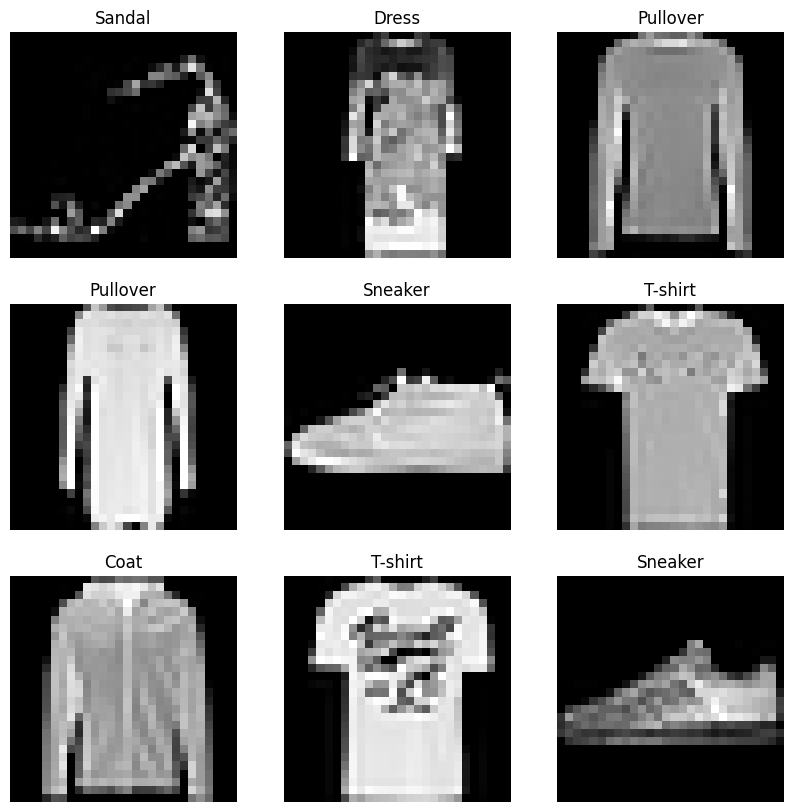

In [3]:
import matplotlib.pyplot as plt

labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (10,10))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train_data), size = (1,)).item()
    image, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
dataloader = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, pin_memory=True)
}

In [6]:
print(type(dataloader))
print(type(dataloader['train']))

<class 'dict'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [7]:
train_features, train_labels = next(iter(dataloader['train']))

Tamaño del batch de feature (input / imagen): torch.Size([64, 1, 28, 28])
Tamaño del batch del label (clase / etiqueta): torch.Size([64])
tamaño de 1 imagen:  torch.Size([1, 28, 28])
tamaño de 1 imagen DESPUES de squeeze:  torch.Size([28, 28])


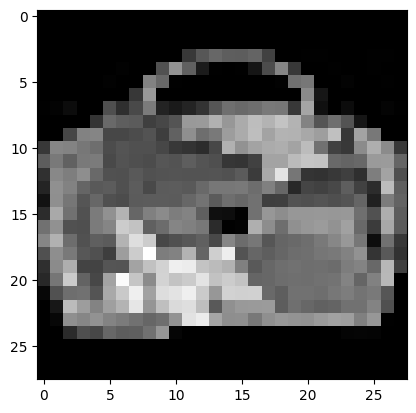

Label: 8


In [8]:
# verifico sus dimensiones
print(f"Tamaño del batch de feature (input / imagen): {train_features.size()}")
print(f"Tamaño del batch del label (clase / etiqueta): {train_labels.size()}")

# tomo 1 imagen para poder visualizarla
# y verifico sus dimensiones

img = train_features[22]
print('tamaño de 1 imagen: ', img.shape)
# le QUITO 1 dimension (la del tamaño del batch) para poder graficar
img = img.squeeze()
print('tamaño de 1 imagen DESPUES de squeeze: ', img.shape)
label = train_labels[22]

# ploteo esa imagen
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [9]:
print('pixel [0,0]: ',img[0][0])
print('pixel maximo: ', torch.max(img))
print('pixel minimo: ', torch.min(img))

pixel [0,0]:  tensor(0.)
pixel maximo:  tensor(1.)
pixel minimo:  tensor(0.)


In [10]:
# bloque de convolución para emplear en mi red

def conv_block(c_in, c_out, k=5, p=2, s=1, pk=3, ps=2, pp=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.Tanh(),                                      # activation
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp)         # pooling
    )


In [27]:
class CNN(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = conv_block(n_channels, 8)
    self.conv1_out = None
    self.conv2 = conv_block(8, 16)
    self.conv2_out = None
    self.conv3 = conv_block(16, 32)
    self.conv3_out = None
    # self.conv4 = conv_block(128, 128)
    # self.conv4_out = None
    self.fc = torch.nn.Linear(512, n_outputs) # verificar la dim de la salida para calcular el tamaño de la fully conected!!
    self.sm = torch.nn.Softmax(dim=1)


    print('Red creada')
    print('arquitectura:')
    print(self)

    # Me fijo en el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)

    # Me fijo en el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)

  def validar_dim(self):
    # es una funcion "forward" que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)

    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)
    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)

    # x = self.conv4(x)
    # print("Tamaño salida conv4: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    # self.conv4_out = self.conv4(self.conv3_out)
    y = self.conv3_out.view(self.conv3_out.shape[0], -1)
    y = self.fc(y)
    x = self.sm(x)
    return y

In [28]:
model = CNN()

Red creada
arquitectura:
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
  (sm): Softmax(dim=1)
)
Número total de capas de CNN (conv+act+polling) + finales :  5
Número total de parámetros a entrenar:  21386


In [29]:
from torchsummary import summary
summary(model.cuda(),(1, 28, 28) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]             208
              Tanh-2            [-1, 8, 28, 28]               0
         MaxPool2d-3            [-1, 8, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]           3,216
              Tanh-5           [-1, 16, 14, 14]               0
         MaxPool2d-6             [-1, 16, 7, 7]               0
            Conv2d-7             [-1, 32, 7, 7]          12,832
              Tanh-8             [-1, 32, 7, 7]               0
         MaxPool2d-9             [-1, 32, 4, 4]               0
           Linear-10                   [-1, 10]           5,130
          Softmax-11            [-1, 1, 28, 28]               0
Total params: 21,386
Trainable params: 21,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [30]:
model.cpu()
model.validar_dim()

Validacion de dimensiones
Ingrese tamaño de entrada: 28
Tamaño entrada:  torch.Size([1, 1, 28, 28])
Tamaño salida conv1:  torch.Size([1, 8, 14, 14])
Tamaño salida conv2:  torch.Size([1, 16, 7, 7])
Tamaño salida conv3:  torch.Size([1, 32, 4, 4])
Tamaño imagen vectorizada:  torch.Size([1, 512])
Tamaño salida fc (nro clases):  torch.Size([1, 10])


In [31]:
from tqdm import tqdm # <- para graficar la barra de avance
import numpy as np

def fit(model, dataloader, epochs=15):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.CrossEntropyLoss()
    epoch_t_loss = []
    epoch_v_loss = []
    epoch_t_acc = []
    epoch_v_acc = []
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            ####
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")

        epoch_t_loss.append(np.mean(train_loss))
        epoch_t_acc.append(np.mean(train_acc))

        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

        epoch_v_loss.append(np.mean(val_loss))
        epoch_v_acc.append(np.mean(val_acc))

    plt.figure()
    plt.plot(epoch_t_loss, 'r')
    plt.plot(epoch_v_loss, 'g')
    plt.title('loss')
    plt.legend(['train loss', 'val loss'])
    plt.grid()

    plt.figure()
    plt.plot(epoch_t_acc, 'r')
    plt.plot(epoch_v_acc, 'g')
    plt.title('acc')
    plt.legend(['train acc', 'val acc'])
    plt.grid()
    plt.show()

val_loss 0.70817 val_acc 0.73855: 100%|██████████| 157/157 [00:01<00:00, 91.88it/s]


Epoch 1/5 loss 1.05442 val_loss 0.70817 acc 0.65448 val_acc 0.73855


val_loss 0.58255 val_acc 0.78414: 100%|██████████| 157/157 [00:01<00:00, 84.43it/s]


Epoch 2/5 loss 0.61755 val_loss 0.58255 acc 0.77579 val_acc 0.78414


val_loss 0.52382 val_acc 0.80543: 100%|██████████| 157/157 [00:02<00:00, 74.60it/s]


Epoch 3/5 loss 0.53548 val_loss 0.52382 acc 0.80315 val_acc 0.80543


val_loss 0.48998 val_acc 0.82026: 100%|██████████| 157/157 [00:01<00:00, 84.71it/s]


Epoch 4/5 loss 0.48647 val_loss 0.48998 acc 0.82181 val_acc 0.82026


val_loss 0.45691 val_acc 0.83360: 100%|██████████| 157/157 [00:01<00:00, 91.93it/s]


Epoch 5/5 loss 0.45136 val_loss 0.45691 acc 0.83529 val_acc 0.83360


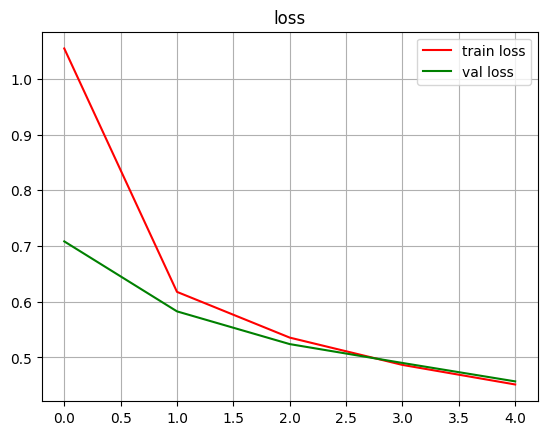

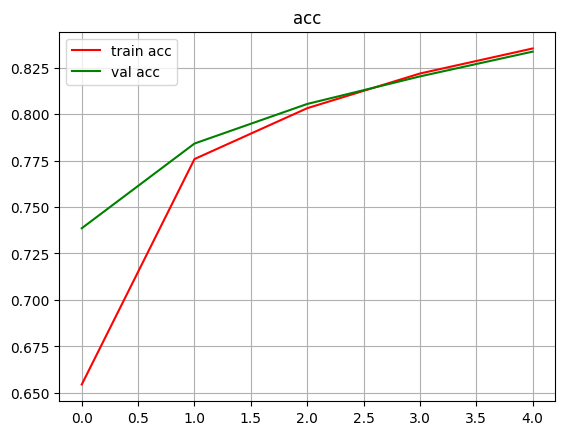

In [32]:
fit(model, dataloader, epochs=5)

Métricas obtenidas para un modelo con **3 capas de convolución**, **8 kernels** de **tamaño 5x5**:

- train loss = 0.45136
- validation loss = 0.45691

- train accuracy = 83.529%
- validation accuracy = 83.360%

## Parte 2.b

Empleando el modelo entrenado y elegido por Ud. en el punto anterior, realice transfer learning para procesar las imágenes del dataset MNIST (los números) e identificar los números mayores o menores a 4,5.
Para el entrenamiento emplee solamente 20.000 muestras del set de entrenamiento y valide con el set de testeo. (al reducir el train set, mantenga equilibrada la distribución de las clases!!)

Pruebe 2 estrategias de transfer learning distintas (acorde a los visto en la teoría) y comente para cada una, cual debería funcionar mejor justificando su respuesta.


Compare los resultados finales y comente.